# Mixture ManifoldHMC with Christophe's Correction

In [1]:
import numpy as np
from numpy.linalg import inv, norm
import matplotlib.pyplot as plt
from scipy.stats import multivariate_normal
from scipy.stats import norm as norm_distribution
from mixture_manifoldhmc import MixtureManifoldHMC
from utils import logf, logp, logf_Jacobian
from zappa import zappa_sampling
from Manifolds.RotatedEllipse import RotatedEllipse
from gaussian_hmc import GaussianTargetHMC

### Settings

In [2]:
Sigma = np.array([[1.0, 0.6], [0.6, 2.0]])
mu = np.zeros(2)                                 
target = multivariate_normal(mean=mu, cov=Sigma)

# Settings for sampling
n = 1            # Number of HMC samples per iteration
m = 20            # Number of Zappa samples per iteration
T = 8            # Total integration time
epsilon = 0.1    # Step size
M = np.eye(2)     # Coviariance Matrix for momentum distribution
alpha = 0.3       # Probability of using HMC
N = 300000         # Total number of samples
s = 1
tol=1.48e-08
a_guess = 1.0

# Data for contour plot
xmin, xmax, xstep = -3, 3, 0.05
ymin, ymax, ystep = -3, 3, 0.05
x_grid, y_grid = np.mgrid[xmin:xmax:xstep, ymin:ymax:ystep]
contour_values = target.pdf(np.dstack((x_grid, y_grid)))

print("Total Zappa probability: {:.3}".format((1 - (n/m))*(1-alpha)))

Total Zappa probability: 0.665


### Uniform Target Distribution

In [4]:
# Starting point
x0 = target.rvs()

x, z = x0, target.pdf(x0)
uniform_samples = x
while len(uniform_samples) < N: 

    # With probability alpha do n steps of HMC 
    if np.random.rand() <= alpha:
        new_samples = GaussianTargetHMC(q0=x, n=n, M=M, T=T, epsilon=epsilon, Sigma=Sigma, mu=mu).sample()  #[1:]

    # With probability 1 - alpha do m steps of Zappa's algorithm
    else:
        new_samples = zappa_sampling(x, RotatedEllipse(mu, Sigma, z), logf, logp, m, s, tol, a_guess)

    uniform_samples = np.vstack((uniform_samples, new_samples))
    x = new_samples[-1]
    z = target.pdf(x)

### Jacobian Correction

We target the following distribution on the manifold

$$
\log f(x) =  - \log||\nabla_x \log \pi(x)|| = -\log ||\Sigma^{-1}(x - \mu)||
$$

One can plot this distribution in terms of the angle.

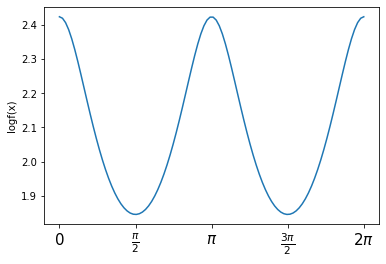

In [5]:
# New distribution on manifold
logf_correct = lambda xy: - np.log(norm(inv(Sigma) @ (xy - mu)))

angles = np.linspace(0, 2*np.pi, num=100)
values = np.array([logf_correct(RotatedEllipse(mu, Sigma, z).to_cartesian(angle)) for angle in angles])
plt.plot(angles, values)
plt.ylabel("logf(x)")
plt.xticks([0, np.pi/2, np.pi, 3*np.pi/2, 2*np.pi], 
           [r"$0$", r"$\frac{\pi}{2}$", r"$\pi$", r"$\frac{3\pi}{2}$", r"$2\pi$"], fontsize=15)
plt.show()

In [6]:
# Starting point
x0 = target.rvs()

x, z = x0, target.pdf(x0)
jacobian_samples = x
while len(jacobian_samples) < N: 

    # With probability alpha do n steps of HMC 
    if np.random.rand() <= alpha:
        new_samples = GaussianTargetHMC(q0=x, n=n, M=M, T=T, epsilon=epsilon, Sigma=Sigma, mu=mu).sample() 

    # With probability 1 - alpha do m steps of Zappa's algorithm
    else:
        new_samples = zappa_sampling(x, RotatedEllipse(mu, Sigma, z), logf_correct, logp, m, s, tol, a_guess)

    jacobian_samples = np.vstack((jacobian_samples, new_samples))
    x = new_samples[-1]
    z = target.pdf(x)

### Uniform vs Corrected Manifold Sampling

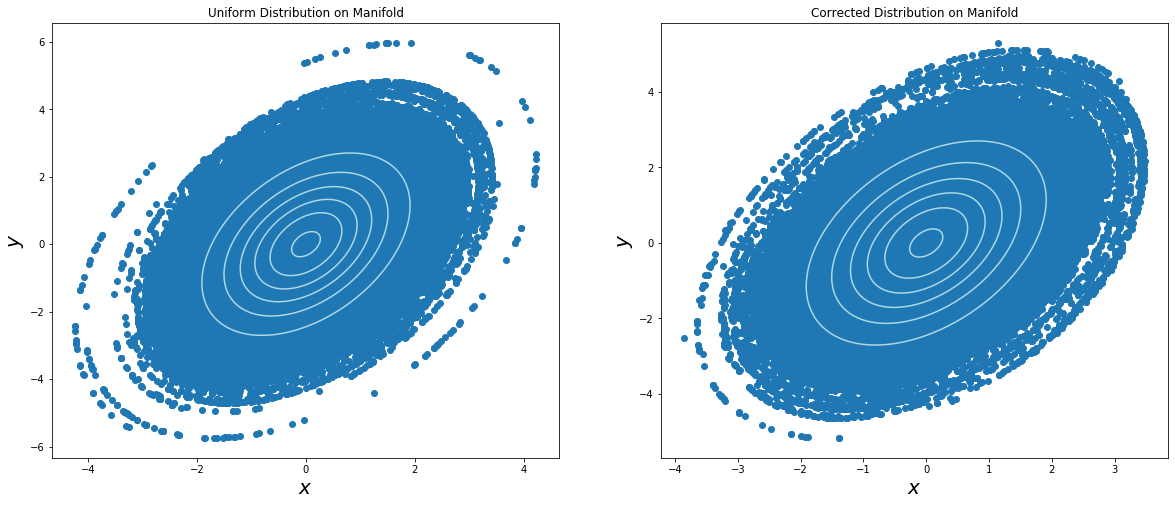

In [7]:
fig, ax = plt.subplots(figsize=(20, 8), ncols=2)

# Uniform samples
ax[0].scatter(uniform_samples[:, 0], uniform_samples[:,1])
ax[0].contour(x_grid, y_grid, contour_values, colors="lightblue")
ax[0].set_xlabel(r"$x$", fontsize=20)
ax[0].set_ylabel(r"$y$", fontsize=20)
ax[0].set_title("Uniform Distribution on Manifold")

# Jacobian samples
ax[1].scatter(jacobian_samples[:, 0], jacobian_samples[:,1])
ax[1].contour(x_grid, y_grid, contour_values, colors="lightblue")
ax[1].set_xlabel(r"$x$", fontsize=20)
ax[1].set_ylabel(r"$y$", fontsize=20)
ax[1].set_title("Corrected Distribution on Manifold")

plt.show()

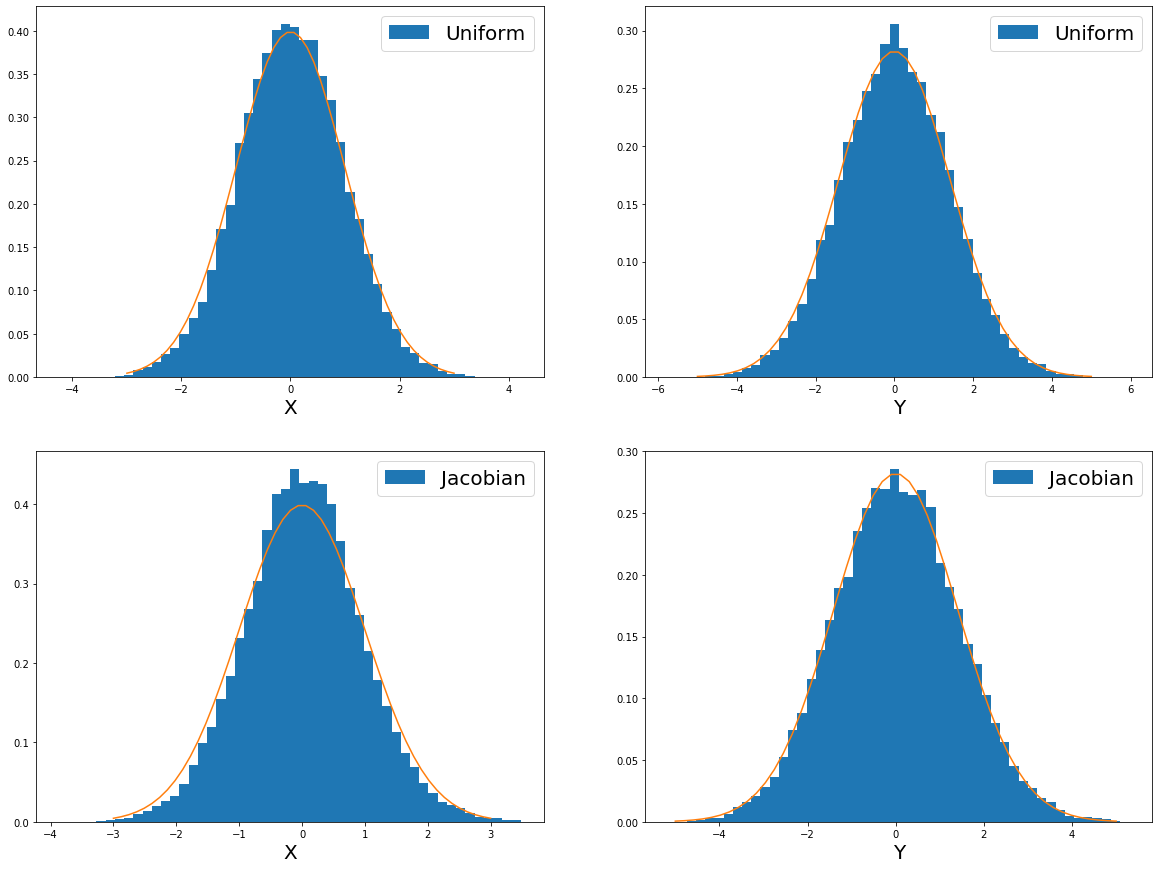

In [8]:
# marginals
marginal_x = norm_distribution(loc=mu[0], scale=np.sqrt(Sigma[0,0]))
marginal_y = norm_distribution(loc=mu[1], scale=np.sqrt(Sigma[1,1]))

# Plotting vars
xs = np.linspace(-3, 3)
ys = np.linspace(-5, 5)

fig, ax = plt.subplots(nrows=2, ncols=2, figsize=(20, 15))

### Uniform
# X space
_ = ax[0, 0].hist(uniform_samples[:, 0], bins=50, density=True, label="Uniform")
ax[0, 0].plot(xs, marginal_x.pdf(xs))
ax[0, 0].legend(fontsize=20)
ax[0, 0].set_xlabel("X", fontsize=20)
# Y space
_ = ax[0, 1].hist(uniform_samples[:, 1], bins=50, density=True, label="Uniform")
ax[0, 1].plot(ys, marginal_y.pdf(ys))
ax[0, 1].legend(fontsize=20)
ax[0, 1].set_xlabel("Y", fontsize=20)

### Jacobian
# X space
_ = ax[1, 0].hist(jacobian_samples[:, 0], bins=50, density=True, label="Jacobian")
ax[1, 0].plot(xs, marginal_x.pdf(xs))
ax[1, 0].legend(fontsize=20)
ax[1, 0].set_xlabel("X", fontsize=20)
# Y space
_ = ax[1, 1].hist(jacobian_samples[:, 1], bins=50, density=True, label="Jacobian")
ax[1, 1].plot(ys, marginal_y.pdf(ys))
ax[1, 1].legend(fontsize=20)
ax[1, 1].set_xlabel("Y", fontsize=20)

plt.show()